# Investigating growth in the model 

To understand how Berlin\'s public transport system evolved over time, we will use NA to track structural changes. The aim for this section is to explore specifically how public transportation in Berlin grew and/or contracted during the period. We want to be able to identify the major historical trends in the evolution of the network and illuminate the connection between historical events like the building of the Berlin Wall with the development of the public transport system. Throughout we will test the analytical potential of different NA methods and metrics for our use case.

It is important to have a focus when using NA techniques because the array of possible tools and methodologies we have at our disposal is vast and needs to be constricted. Even with the focus purely on network growth and contraction we have access to many different theories, methods and metrics that will help us describe the data and provide a perspective on the evolution of the system.

In [20]:
# Loading necessary libraries, some must first be installed using pip


# Data Handling 
import numpy as np
import pandas as pd
from collections import Counter

# Network Analysis
import networkx as nx


# Data Visualization
import matplotlib.pyplot as plt

In [21]:
H = nx.read_graphml('base-graph.graphml')

In [22]:
# creating network snapshots to better extrapolate datapoints at specific snapshots
snapshot_years = [1946, 1951, 1956, 1960, 1961, 1964, 1967, 1971, 1976, 1980, 1982, 1984, 1989]

def create_subgraph(G, target_year):
    subgraph_for_year = nx.Graph()
    for node, data in G.nodes(data=True):
        if str(target_year) in data['years']:
            subgraph_for_year.add_node(node, **data)

    for edge in G.edges(data=True):
        node1 = edge[0]
        node2 = edge[1]
        data = edge[2]
        if data["year"] == int(target_year):
            if subgraph_for_year.has_node(node1) and subgraph_for_year.has_node(node2):
                subgraph_for_year.add_edge(node1, node2, label=data.get('label'), type=data.get('edge_type'), year=data['year'], weight=data.get("weight"), traverses=data["traverses"])
    return(subgraph_for_year)

snapshot_dict = {}  # Store subgraphs in a dictionary

for year in snapshot_years:
    subgraph = create_subgraph(H, year) 
    snapshot_dict[f"subgraph_{year}"] = subgraph

## General network expansion/contraction

As a starting point, we simply see how the number of nodes and edges have changed during the period under observation.

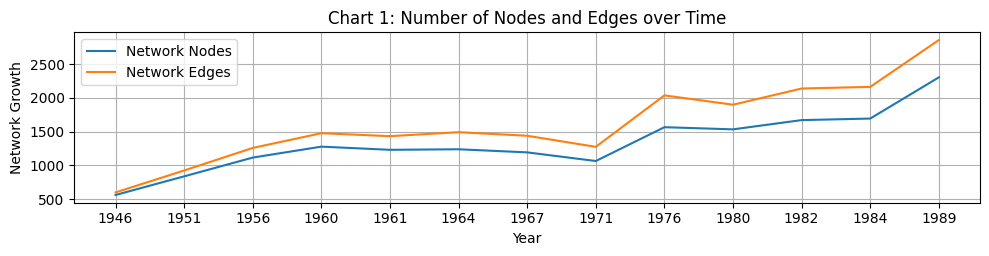

In [23]:
years = []
network_sizes = [] 
network_edges = []
number_of_lines = []

for year, graph in snapshot_dict.items():
    years.append(year[-4:])
    network_sizes.append(graph.number_of_nodes())
    network_edges.append(graph.number_of_edges())

plt.figure(figsize=(10, 8))


plt.subplot(4, 1, 4)  # Additional subplot for network sizes
plt.plot(years, network_sizes, label='Network Nodes')
plt.plot(years, network_edges, label='Network Edges')
plt.xlabel('Year')
plt.ylabel('Network Growth')

plt.tight_layout()  
plt.legend()
plt.title('Chart 1: Number of Nodes and Edges over Time')
plt.grid(True)
plt.show()

The node and edge graphs run almost parallel to each other although the difference between the number of nodes and edges increases gradually. We see clearly a gradual growth over time with three marked periods of increase, these are 1946-1960, 1971-1976 and 1984-1989. From the historical literature we know that the network growth immediately following 1946 is a response to the reconstruction of the transportation system after the war.[^52] We know that the increase in the second period will, to a considerable degree, be caused by the sources from 1975 including all bus stations in a line, when they previously only had the most important ones. The third period of marked increase is harder to explain. One suggestion is that we determine how the number of lines changed during this period and the average number of stations per line so that we get a better insight into our node and edge changes. The line chart below sheds light on the factors behind these changes in network expansion.

[^52]: Christian Dirks, Christian Mentel, pg. 22.

In [24]:
def analyze_lines(graph):
    all_lines = set()  
    for node1, node2, data in graph.edges(data=True):
        label = data.get('label')
        edge_type = data.get('type')
        traverses = data.get("traverses")

        identifier = str(label+edge_type+traverses)
        if identifier: 
            all_lines.add(identifier)  

    num_lines = len(all_lines)

    return num_lines, all_lines

def calculate_average_nodes_per_line(graph):
    line_node_counts = {}  

    for node1, node2, data in graph.edges(data=True): 
        label = data.get('label')
        edge_type = data.get('type')
        traverses = data.get("traverses")

        identifier = str(label+edge_type+traverses)
        if identifier:
            line_node_counts[identifier] = line_node_counts.get(identifier, 0) + 2  # Count both edge nodes

    if line_node_counts:
        average_nodes = sum(line_node_counts.values()) / len(line_node_counts)
    else:
        average_nodes = 0

    return average_nodes

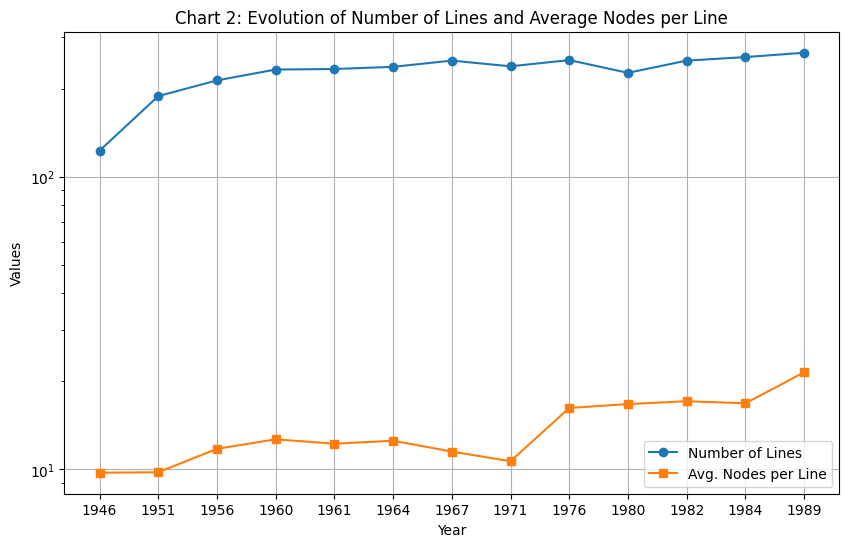

In [25]:
average_nodes_data = []  # List to store average nodes per line
years = []
number_of_lines_data = []
new_lines_count = []  # Storage for new line counts
lost_lines_count = []  # Storage for lost line counts
all_lines = None  # Initialize to track lines across snapshots

for year, graph in snapshot_dict.items():
    years.append(year[-4:])

    num_lines, current_lines = analyze_lines(graph)  
    number_of_lines_data.append(num_lines) 

    if all_lines:  
        new_lines = current_lines - all_lines  
        lost_lines = all_lines - current_lines  
        new_lines_count.append(len(new_lines))  # Count of new lines
        lost_lines_count.append(len(lost_lines))  # Count of lost lines 

    all_lines = current_lines 
    average_nodes_per_line = calculate_average_nodes_per_line(graph)
    average_nodes_data.append(average_nodes_per_line)

plt.figure(figsize=(10, 6))

# Plot number of lines (you might want to adjust the axis or use twinx)
plt.semilogy(years, number_of_lines_data, marker='o', label='Number of Lines') 

# Plot average nodes per line 
plt.semilogy(years, average_nodes_data, marker='s', label='Avg. Nodes per Line') 

plt.xlabel('Year')
plt.ylabel('Values') 
plt.title('Chart 2: Evolution of Number of Lines and Average Nodes per Line')
plt.grid(True)
plt.legend() 
plt.show()

In our logarithmic results we see that the number of average nodes per line seems to have increased primarily in 1976. This supports our understanding of the sources in that it proves that the change in the way the sources recorded stations was that more, most likely already existing stations, were being added to already existing lines.

We see the same increase in 1989 although to a lesser extent. Without further external information, we cannot be sure why this is the case. However, there are at least two possible explanations. Firstly, similar to the period 1971-1976, it may be that stations that were already being serviced were now being written into the Fahrplanbuch source or alternatively, it may be that services started making more stops during the period. We can investigate further by probing into how consistent the lines were throughout the period.

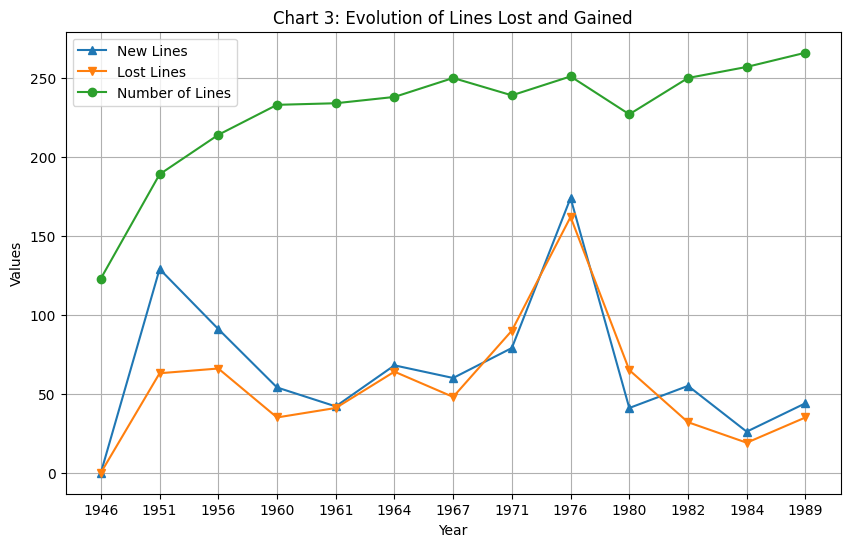

In [26]:
new_lines_count.insert(0, 0)  # Insert 0 at the beginning
lost_lines_count.insert(0, 0) 

plt.figure(figsize=(10, 6))

# Plot new and lost lines
plt.plot(years, new_lines_count, marker='^', label='New Lines')
plt.plot(years, lost_lines_count, marker='v', label='Lost Lines') 
plt.plot(years, number_of_lines_data, marker='o', label='Number of Lines') 

plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Chart 3: Evolution of Lines Lost and Gained')
plt.grid(True)
plt.legend() 
plt.show()

In this line chart, we see the changes in lines, and explicitly the number of new lines and the number of lost lines between network snapshots. There are clearly a lot of changes being displayed, relative to the number of lines. The reason for this might be heavily impacted however by our model. Since we are relying on the semantic line name to measure change, we are susceptible to regard renaming of lines as establishing new lines. This is most likely the case, explaining why we have similar counts for new lines and lost lines for many of the snapshots. Particularly for 1976, we can expect that many of the lines were renamed between then and the previous snapshot.

### Network evolution in East vs. West Berlin

Now let us see how the trend of network growth appears in East and West Berlin individually.

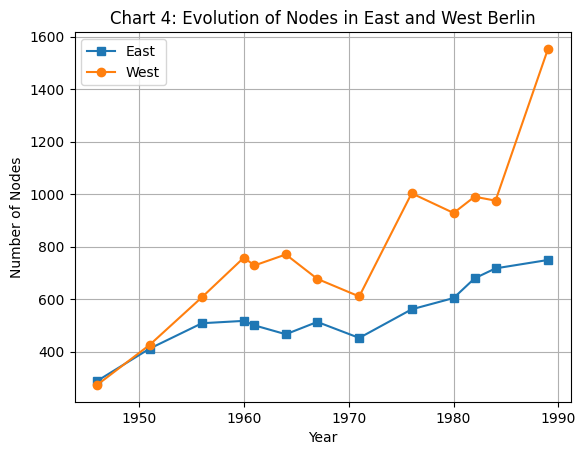

In [27]:
snapshot_count_dict = {}

for year, graph in snapshot_dict.items():
    admin_side_count = Counter()  # For counting lines within and between sectors
    for n, data in graph.nodes(data=True): 
        admin_side = data.get("east_west")
        admin_side_count[admin_side] += 1
        # count all the values and then display

    snapshot_count_dict[year] = admin_side_count 

years = [int(key.split('_')[-1]) for key in snapshot_dict.keys()]  # Extract years
east_counts = [count['east'] for count in snapshot_count_dict.values()]
west_counts = [count['west'] for count in snapshot_count_dict.values()]

plt.plot(years, east_counts, marker='s', label='East')
plt.plot(years, west_counts, marker='o', label='West')

plt.xlabel('Year')
plt.ylabel('Number of Nodes')
plt.title('Chart 4: Evolution of Nodes in East and West Berlin')
plt.grid(True)
plt.legend()
plt.show()

While we can see the general trend of network expansion in both East and West Berlin, the exact figures are complex and highly dependent on the modelling of the network. The changes to the way the West Berlin Fahrplanbücher recorded stations in the mid-1970s clearly had a large impact on our model, and the changes from 1971-1976 must be perceived with this in mind. However, because we are able to distinguish between the trends for East and West Berlin, we do notice that starting in 1971, the number of nodes rose at a fairly steady rate. Looking at the data, we can identify three periods of change in East Berlin. The first period from 1946-1956, and to a degree until 1960 is characterised by network growth. This is clearly a product of post-war reconstruction. As the old transportation system is being rebuilt, we see a rapid rise in network growth. To an extent, this contradicts the literature on the period, which describes the rebuilding process to have been completed by the early 1950s.[^53] In our network, especially for West Berlin, we see network growth continue strongly until 1960. However, we also know that the decision to replace the tram system was made in Autumn 1953 and was completed in 1967.[^54] We know that the tram system was being replaced by bus services, which have more frequent stations.[^55] With this historical context, we might ask if the increase in stations in West Berlin during this period may be due to the removal of tram lines in favour of bus lines. To investigate this, we can look at the network evolution by transportation type.

[^53]: Ibid., pg. 46.

[^54]: Wolfgang Reinhardt, Öffentlicher Personenverkehr in zwei deutschen Staaten, pg.696.

[^55]: J.W. Korte, Stadtverkehr: Gestern, heute und morgen, Berlin 1959, pg. 109.

In [28]:
def create_sector_subgraph(graph, sector):
    sector_nodes = [node for node, data in graph.nodes(data=True) if data.get('east_west') == sector]
    return graph.subgraph(sector_nodes)


def create_type_subgraph(graph, line_type):
     type_edges = [(u, v) for u, v, data in graph.edges(data=True) if data.get('type') == line_type]
     return graph.edge_subgraph(type_edges)

def get_node_type(node_data):
    return node_data.get('type')  

def count_nodes_by_type(subgraph, node_type):
    count = 0
    for node, data in subgraph.nodes(data=True):
        if get_node_type(data) == node_type:
            count += 1
    return count

In [29]:
ubahn_west = []
sbahn_west = []
bus_west = []
tram_west = []
subgraphs_east = {}
subgraphs_west = {}

for year, graph in snapshot_dict.items():
    years.append(year[-4:])

    east_subgraph = create_sector_subgraph(graph, 'east')
    west_subgraph = create_sector_subgraph(graph, 'west')

    subgraphs_east[year] = east_subgraph
    subgraphs_west[year] = west_subgraph

    ubahn_west.append(count_nodes_by_type(west_subgraph, "u-bahn"))
    sbahn_west.append(count_nodes_by_type(west_subgraph, "s-bahn"))
    bus_west.append(count_nodes_by_type(west_subgraph, "bus"))
    tram_west.append(count_nodes_by_type(west_subgraph, "strassenbahn"))

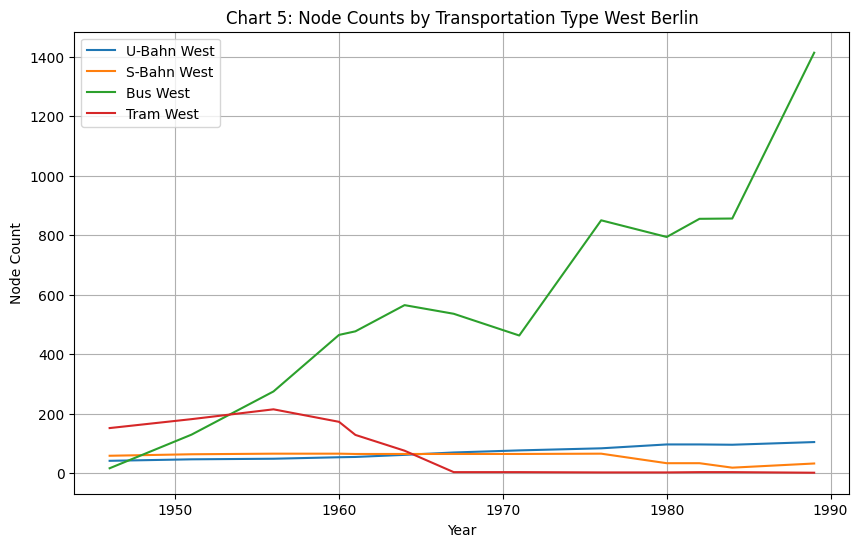

In [30]:
# X-axis (years)
years = [int(key.split('_')[-1]) for key in snapshot_dict.keys()]  # Assuming this is correct

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size as needed

plt.plot(years, ubahn_west, label='U-Bahn West')
plt.plot(years, sbahn_west, label='S-Bahn West')
plt.plot(years, bus_west, label='Bus West')
plt.plot(years, tram_west, label='Tram West')

# Labels, title, legend
plt.xlabel('Year')
plt.ylabel('Node Count')  # Adjust y-axis label as needed
plt.title('Chart 5: Node Counts by Transportation Type West Berlin')
plt.legend()

# Grid and display
plt.grid(True)
plt.show()

It is evident that the growth of the bus system in West Berlin was rapid in the years 1956-1960. Although the tram system did contract during this period, it only started with a rapid contraction from 1960 onwards and decommissioning was complete by 1967. The data might then lead us to believe that the bus network was already being expanded rapidly in West Berlin before the decision to dispel with the tram system was made. This insight can help our understanding of the decision made to remove the tram system in the meeting of the supervisory board of the West-BVG in Autumn 1953. We could hypothesise that the expansion of the bus network was successfully progressing previous to this meeting and so this was seen as evidence that this approach would work.

To fully capture the expansion of the transportation system though we should also investigate how the total capacity of the network evolved. We can do this using the previously calculated weight measures of edges of the network.

In [31]:
def get_total_strength(G):
  """Calculates the sum of all edge weights in a networkx graph"""
  total_weight = sum(data["weight"] for node1, node2, data in G.edges(data=True))
  return total_weight

# Iterate through snapshots and store results
strength_over_time_total = []
strength_over_time_west = []
strength_over_time_east = []

for year, graph in snapshot_dict.items():
  east_subgraph = create_sector_subgraph(graph, 'east')
  west_subgraph = create_sector_subgraph(graph, 'west')

  strength_over_time_total.append(get_total_strength(graph))
  strength_over_time_east.append(get_total_strength(east_subgraph))
  strength_over_time_west.append(get_total_strength(west_subgraph))

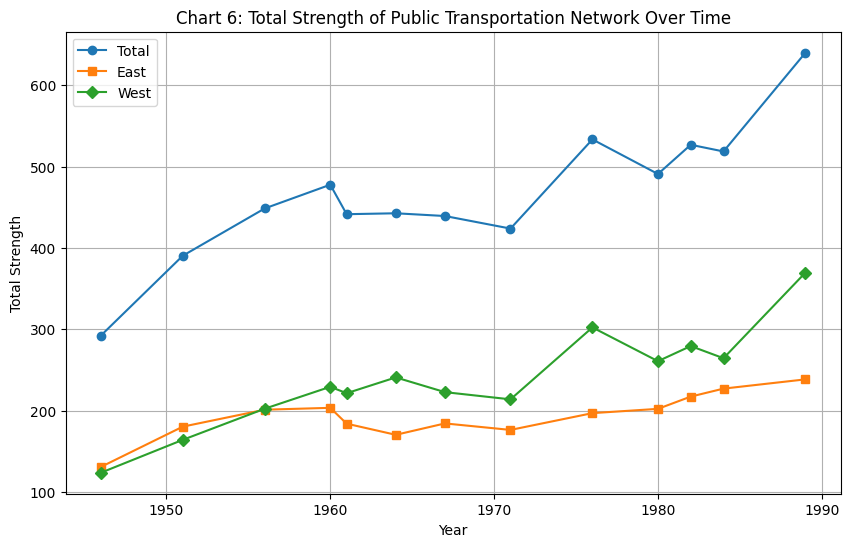

In [32]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(years, strength_over_time_total, marker='o', linestyle='-', label="Total")
plt.plot(years, strength_over_time_east, marker='s', linestyle='-', label="East")
plt.plot(years, strength_over_time_west, marker='D', linestyle='-', label="West")
plt.xlabel('Year')
plt.ylabel('Total Strength')
plt.title('Chart 6: Total Strength of Public Transportation Network Over Time')
plt.grid(True)
plt.legend()
plt.show()

This chart shows us that West Berlin consistently had a transport network that could serve more people than East Berlins. This is unsurprising given that West Berlin consistently had a much higher population than East Berlin.[^56]

[^56]: Statistisches Landesamt Berlin, Statistisches Jahrbuch 1990, Berlin 1990, pg. 42.

We now want to take a closer look at which transportation systems were contributing the most to the overall strength of the network. This should help inform our understanding of the importance of different transportation types to the network.

In [33]:
# Calculates the sum of edge weights grouped by edge type.
def get_weights_by_type(G):
    """Calculates the sum of edge weights grouped by edge type"""
    weights_by_type = {}
    for node1, node2, data in G.edges(data=True):
        edge_type = data["type"]
        weight = data["weight"]
        if edge_type not in weights_by_type:
            weights_by_type[edge_type] = 0
        weights_by_type[edge_type] += weight
    return weights_by_type

def prepare_stacked_bar_data(snapshots):
    data = []
    for year, graph in snapshots:
        weights_by_type = get_weights_by_type(graph)
        snapshot_data = (year[-4:], list(weights_by_type.keys()), list(weights_by_type.values()))
        data.append(snapshot_data)

    return data

In [34]:
# Assuming you have your snapshots ready 
data_total = prepare_stacked_bar_data(snapshot_dict.items())
data_west = prepare_stacked_bar_data(subgraphs_west.items())
data_east = prepare_stacked_bar_data(subgraphs_east.items())

def flatten_data(data):
    new_data = []
    for year, transport_types, weights in data:
        for t_type, weight in zip(transport_types, weights):
            new_data.append({'Year': year, 'Transport Types': t_type, 'Weights': weight}) 
    return new_data

flattened_data = flatten_data(data_total)  
flattened_east = flatten_data(data_east) 
flattened_west = flatten_data(data_west) 


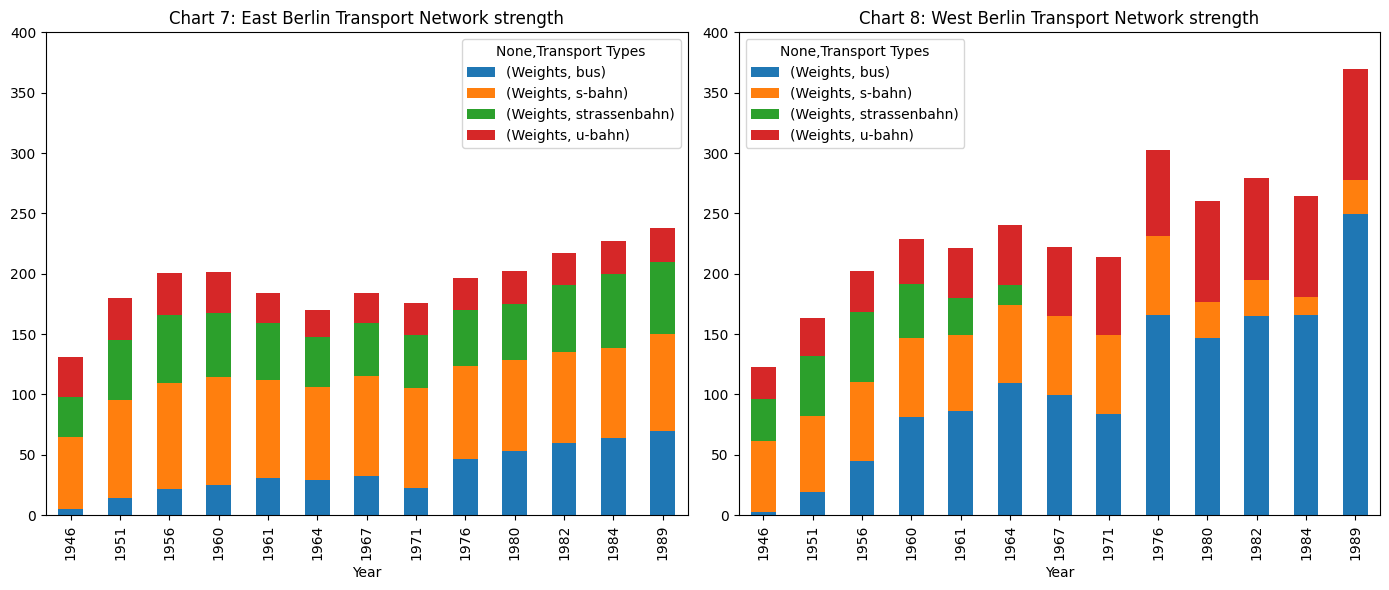

In [35]:
# Filter for the desired transport types
transport_types = ['bus', 's-bahn', 'u-bahn', 'strassenbahn']

df_west = pd.DataFrame(flattened_west, columns=['Year', 'Transport Types', 'Weights'])
df_west = df_west[df_west['Transport Types'].isin(transport_types)]  # Filtering
df_west.set_index(['Year', 'Transport Types']).unstack(fill_value=0)

df_east = pd.DataFrame(flattened_east, columns=['Year', 'Transport Types', 'Weights'])
df_east = df_east[df_east['Transport Types'].isin(transport_types)]  # Filtering
df_east.set_index(['Year', 'Transport Types']).unstack(fill_value=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))  

# Plot East
df_east.set_index(['Year', 'Transport Types']).unstack(fill_value=0).plot.bar(stacked=True, ax=axes[0])
axes[0].set_title('Chart 7: East Berlin Transport Network strength')
axes[0].set_ylim(0, 400)  # Set the y-axis limits

# Plot West
df_west.set_index(['Year', 'Transport Types']).unstack(fill_value=0).plot.bar(stacked=True, ax=axes[1])
axes[1].set_title('Chart 8: West Berlin Transport Network strength')
axes[1].set_ylim(0, 400)  # Set the y-axis limits

plt.tight_layout()
plt.show()

First, let's take a look at the stacked bar chart for West Berlin. We see that as the tram disappears in West Berlin, it is replaced by both bus and the U-Bahn in terms of network strength. This is verified by BVG sources which confirm that the plan was for the U-Bahn and bus systems to replace the tram.[^57] However, we also see that the network strength was not enhanced by the removal of the tram system but actually slightly decreased in West Berlin. Of course, perspective on the network needs to take into account two further historical processes, which had an effect on network strength at the time.

Both East and West Berlin had had weakened networks during the 1960s compared to earlier periods. This shared characteristic leads us to assume that a common cause existed for contraction during the period. One could suppose that the building of the wall and the final cutting of transportation between the two systems had a negative effect on public transport strength at the time.

We also have to consider that West Berlin was removing tram transportation primarily as part of the endeavour to make the city more car friendly. The plan to create inner-city highways was to be beneficial to the bus system, however, the main beneficiary was private automobile transportation in the city. This form of transportation, and to a lesser extent bicycle transportation exist in parallel to our network. When looking at public transportation, we must be aware that we are not getting a full picture of mobility.

In addition, it is difficult to compare the absolute values of the strength of the two networks without looking at the populations that they had to serve. When looking at the strength per capita, we see that East Berlin's public transportation system is consistently stronger than West Berlin\'s, by a significant margin of up to a third. The results of this are not surprising when reflecting on the transportation policy and economic contexts of the two Germanies. We know that the development of public transportation systems is dictated by the political compromise achieved between different wants and needs. In the German Democratic Republic (DDR) public transportation played a very important role, with 75% of people being transported with public transportation in 1977.[^58] While this was in part in line with socialist ideology it was also due to the economic constraints on private automobility in the DDR. Production constraints and regulated pricing meant that although demand for cars was high, supply was slow and it could take more than a decade for a car to be delivered.[^59] In comparison, West Germany and West Berlin in particular, placed a much higher emphasis and had less constraints on personal automobile transportation.[^60]

[^57]: Berliner Verkehrs-Betriebe, pg. 31.

[^58]: Wolfgang Reinhardt, Öffentlicher Personenverkehr in zwei deutschen Staaten, pg. 676.

[^59]: Mitteldeutscher Rundfunk, Autos in der DDR, https://www.mdr.de/geschichte/ddr/wirtschaft/verkehr/auto-industrie-wartezeit-trabi-100.html, 18 April 2024.

[^60]: Christoph Bernhardt, pg. 324.

| Year | West Berlin – Total population | West Berlin - Network Strength | West Berlin - Strength per capita (Scaled Strength by factor of 1000) | East Berlin – Total population | East Berlin - Network Strength | East Berlin - Strength per capita (Scaled Strength by factor of 1000) |
| ---- | ------------------------------ | ------------------------------ | --------------------------------------------------------------------- | ------------------------------ | ------------------------------ | --------------------------------------------------------------------- |
| 1946 | 2012532                        | 143.49                         | 0.071297873                                                           | 1073799                        | 129.74                         | 0.120826459                                                           |
| 1951 | 2172291                        | 183.87                         | 0.084643145                                                           | 1184000                        | 173.26                         | 0.146330245                                                           |
| 1956 | 2223777                        | 220.93                         | 0.099346884                                                           | 1121873                        | 194.62                         | 0.173480976                                                           |
| 1960 | 2202241                        | 244.80                         | 0.111157703                                                           | 1071775                        | 199.55                         | 0.18618529                                                            |
| 1961 | 2197408                        | 238.56                         | 0.108562077                                                           | 1055283                        | 177.46                         | 0.168164352                                                           |
| 1964 | 2200228                        | 244.16                         | 0.110971563                                                           | 1070731                        | 174.91                         | 0.163357752                                                           |
| 1967 | 2163306                        | 231.90                         | 0.107198175                                                           | 1082091                        | 184.69                         | 0.170677868                                                           |
| 1971 | 2083987                        | 225.96                         | 0.108425436                                                           | 1087982                        | 180.34                         | 0.165754357                                                           |
| 1976 | 1950706                        | 310.10                         | 0.158967168                                                           | 1106267                        | 204.63                         | 0.184974622                                                           |
| 1980 | 1896230                        | 253.30                         | 0.133583432                                                           | 1152529                        | 223.02                         | 0.193504495                                                           |
| 1982 | 1869582                        | 275.31                         | 0.147256923                                                           | 1173028                        | 237.37                         | 0.202353559                                                           |
| 1984 | 1848585                        | 268.29                         | 0.145130823                                                           | 1196871                        | 239.00                         | 0.19968494                                                            |
| 1989 | 2130525                        | 363.27                         | 0.170508394                                                           | 1279212                        | 262.33                         | 0.205069895                                                           |

Table 2: Comparison East and West Berlin in terms of population and network strength

Our findings can inform our understanding of this dichotomy because we have metrics that support the argument that East Berlin had a stronger public transportation system then West Berlin relative to population size. Of course, the numbers need to be contextualised, based on the limitations of the model that were discussed but they do lead to a strong conclusion about the comparative strengths of public transportation in the two Berlins.

### Taking stock of initial network overview

We now want to take stock of what we have learned about our networks and how they can inform our understanding of the period. Throughout all of our metrics we saw overlapping trends that point to the fact that the transportation system can be split into phases of growth and phases of stagnation or even decline. We clearly see that the period of the 1960s remained stagnant for the network. Both in terms of number of nodes and edges and the number of lines, neither East nor West Berlin experiences any increase in their network size. We even see a decrease in terms of node size and number of lines between 1960 and 1961. We have to remember though that this is merely one of many possible perspectives on growth. We could for example hypothesise that with stagnant network size during the 1960s, internal connectivity within East and West sub-networks may have increased to compensate for decreased interconnectivity. To investigate this, we could look at changes in network density and the evolution of the shortest average path of the network.

This chapter\'s analysis of the Berlin transportation network\'s evolution between 1946 and 1989 highlights the intricate interaction between historical events, political ideologies, and urban planning decisions. We have investigated how the public transportation network we modelled grew and contracted in the period. Throughout, we have shown that there are many different metrics to analyse the network and they are all perspectives that should inform our understanding of how the system works. By comparing the metrics describing growth, we are now aware of a few overarching processes of change in the network. We have carried out the following in this chapter:

Several key findings did emerge from our initial analysis. Firstly, the period immediately following World War II saw significant network expansion in both East and West Berlin as the cities rebuilt infrastructure. This reconstruction may have lasted longer than previously assumed in historical research, lasting right up until 1960. We also found diverging transportation policies. West Berlin\'s shift towards car-centric infrastructure and the removal of the tram system contrasted sharply with East Berlin\'s continued emphasis on a strong public transportation network. This is evident in the consistently strength per capita of East Berlin's network. Finally, we also established that there are evident source biases. The inherent limitations in how stations were recorded over time, specifically the change in notation in West Berlin underscores the need for critical source evaluation in historical network modelling.

In [37]:
# Saving part of graph for future use
np.save('subgraphs_east.npy', subgraphs_east) 

np.save('snapshot_dict.npy', snapshot_dict) 